# LOADING LIBS AND MODULES

In [ ]:
# core
import numpy as np
import pandas as pd
import datetime as dt
import yaml
import pickle

# explainability
# import shap

# modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

# models
from xgboost import XGBRegressor

# otm
import optuna

# our functions
import utils_gpu

import warnings
warnings.filterwarnings('ignore')

# LOADING THE PARAMETER CONFIGURATION FILE

In [ ]:
# loading up the YAML dictionary that contains all the parameters for the model
with open("model_params.yml", "r") as f:
    configs = yaml.safe_load(f)

# SETTING UP DEFAULTS AND PARAMETERS

In [ ]:
# showing all columns in a pandas dataframe
pd.options.display.max_columns = None

# extracting the keys associated with the parameters
RANDOM_STATE = configs['RANDOM_STATE']
NUMBER_OF_FOLDS = configs['NUMBER_OF_FOLDS']
STRATIFICATION = configs['STRATIFICATION']
FEATURE_STRATIFICATION = configs['FEATURE_STRATIFICATION']
EVAL_FEATURES = configs['EVAL_FEATURES']

FEATURE_COLUMNS = configs['FEATURES']
LABEL_COLUMNS = configs['TARGET']

PREPROCESSING = configs['PREPROCESSING']

# OPTUNA AND MODEL PARAMS
OPTUNA_PARAMS = configs['OPTUNA_PARAMS']
MODEL_RANGE_PARAMS = OPTUNA_PARAMS['MODEL']

# SHAP PARAMS
SHAP_PARMS = configs['SHAP_PARAMS']
SHAP_SAMPLE = SHAP_PARMS['SHAP_SAMPLE']

# LOADING THE DATA

In [ ]:
print("Loading the dataset containing the training data for the demand forecasting model.")
df = pd.read_parquet('../../data/processed/processed_data.parquet')
df['week_of_year'] = df['week_of_year'].astype(int)
df = df.sort_values(["internal_product_id", "internal_store_id", "week_of_year"]).reset_index(drop=True)
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

In [ ]:
df_holiday = pd.read_csv('../../data/processed/processed_usa_holiday.csv')

df_holiday['Date'] = pd.to_datetime(df_holiday.Date)
df_holiday['week_of_year'] = df_holiday.Date.dt.strftime("%U").astype(int)
df_holiday['holiday'] = 1

In [ ]:
df = df.merge(right = df_holiday.loc[df_holiday.Date.dt.year == 2022, ['week_of_year','holiday']], how='left', on='week_of_year')
df['holiday'] = df['holiday'].fillna(0)

In [ ]:
# transforming columns
df['premise'] = df['premise'].map({'online': 1, 'fisica': 0})

In [ ]:
# Fill NaN values in "_sum" columns
cols_sum = df.columns[df.columns.str.contains("sum")]
df[cols_sum] = df[cols_sum].fillna(0)

In [ ]:
# impact of proportions
df['discount_rate_month'] = (df['previous_month_discount_sum'] / df['previous_month_gross_value_sum']).fillna(0)
df['discount_rate_month'] = df['discount_rate_month'].replace([np.inf, -np.inf], 0)

df['profit_margin_month'] = (df['previous_month_gross_profit_sum'] / df['previous_month_gross_value_sum']).fillna(0)
df['profit_margin_month'] = df['profit_margin_month'].replace([np.inf, -np.inf], 0)

# trends
grp = df.groupby(['internal_product_id','internal_store_id'])

df['quantity_lag1'] = grp['quantity'].shift(1)
df['quantity_lag2'] = grp['quantity'].shift(2)
df['quantity_lag3'] = grp['quantity'].shift(3)
df['quantity_lag4'] = grp['quantity'].shift(4)
df['quantity_lag5'] = grp['quantity'].shift(5)

# SEPARATING THE FEATURES BY TYPE

In [ ]:
# mapping which columns should be treated as numerical columns - excluding cyclical features
NUMERIC_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes(np.number).columns if column not in PREPROCESSING['CYCLICAL_FEATURES'].keys()]
# mapping which columns should be treated as categorical columns
CATEGORICAL_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes('object').columns]

# SPLITTING THE DATA

### Mapping which instances should be placed in the train and test splits

In [ ]:
# splitting the data into training and testing sets
# training set: all data before December 2022
X_train = df.loc[df.month != 12, FEATURE_COLUMNS]
y_train = df.loc[df.month != 12, [LABEL_COLUMNS]]
# test set: all data from December 2022 onwards
X_test = df.loc[df.month == 12, FEATURE_COLUMNS]
y_test = df.loc[df.month == 12, [LABEL_COLUMNS]]

### Creating the cross validation folds

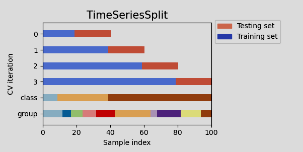

In [ ]:
# creating the stratified k fold instance
tscv = TimeSeriesSplit(n_splits=NUMBER_OF_FOLDS)

## TRAINING WITH CROSS VALIDATION

### OTM Hyperparams Optuna

In [ ]:
def defining_hyperparams(trial, hyperparam_ranges):
    v1 = trial.suggest_int('max_depth', hyperparam_ranges['max_depth'][0], hyperparam_ranges['max_depth'][1], log=hyperparam_ranges['max_depth'][2])
    v2 = trial.suggest_int('n_estimators', hyperparam_ranges['n_estimators'][0], hyperparam_ranges['n_estimators'][1], log=hyperparam_ranges['n_estimators'][2])
    v3 = trial.suggest_float('learning_rate', hyperparam_ranges['learning_rate'][0], hyperparam_ranges['learning_rate'][1], log=hyperparam_ranges['learning_rate'][2])
    v4 = trial.suggest_float('reg_alpha', hyperparam_ranges['reg_alpha'][0], hyperparam_ranges['reg_alpha'][1], log=hyperparam_ranges['reg_alpha'][2])
    v5 = trial.suggest_float('reg_lambda', hyperparam_ranges['reg_lambda'][0], hyperparam_ranges['reg_lambda'][1], log=hyperparam_ranges['reg_lambda'][2])
    v6 = trial.suggest_float('min_child_weight', hyperparam_ranges['min_child_weight'][0], hyperparam_ranges['min_child_weight'][1], log=hyperparam_ranges['min_child_weight'][2])
    v7 = trial.suggest_float('subsample', hyperparam_ranges['subsample'][0], hyperparam_ranges['subsample'][1], log=hyperparam_ranges['subsample'][2])
    v8 = trial.suggest_float('colsample_bytree', hyperparam_ranges['colsample_bytree'][0], hyperparam_ranges['colsample_bytree'][1], log=hyperparam_ranges['colsample_bytree'][2])
    return {'max_depth':v1, 'n_estimators':v2, 'learning_rate':v3, 'reg_alpha':v4,
            'reg_lambda':v5, 'min_child_weight':v6, 'subsample':v7, 'colsample_bytree':v8}

In [ ]:
# Configuring and execute the study
study = optuna.create_study(study_name='best_model', directions=[OPTUNA_PARAMS['DIRECTION'], OPTUNA_PARAMS['DIRECTION']])
study.set_metric_names(["score_validation", "score_overfitting"])

study.optimize(utils_gpu.create_objective_function(hyperparam_ranges        = MODEL_RANGE_PARAMS,
                                            tscv                            = tscv,
                                            x_data                          = [X_train,y_train],
                                            regressor_model                 = XGBRegressor,
                                            columns_to_use                  = [FEATURE_COLUMNS, LABEL_COLUMNS, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS],
                                            eval_features                   = EVAL_FEATURES,
                                            preprocessing                   = PREPROCESSING,
                                            random_state                    = RANDOM_STATE,
                                            defining_hyperparams_function   = defining_hyperparams,
                                            multi_scores                    = True),
                                            n_trials                        = OPTUNA_PARAMS['TRIALS']
)

In [ ]:
# saving best params of otm optuna into variable
_, best_params = utils_gpu.get_best_params(study)
print(best_params)

## TRAINING WITH BEST PARAMS

In [ ]:
# dataframe with the predictions and expected values
df_results = pd.DataFrame()

# dataframe to hold important features of models
df_feature_importances = pd.DataFrame()

# dictionary to hold the cross validation results from each fold

## FITTING THE MODEL THE LAST TIME

### Re-creating the pre-processing pipeline

In [ ]:
pipe_preproc = utils_gpu.create_preprocessing_pipeline(preprocessing_configs=PREPROCESSING, numeric_columns=NUMERIC_COLUMNS, categorical_columns=CATEGORICAL_COLUMNS)

### Fitting the model  to the training data

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', pipe_preproc), ('model', XGBRegressor(random_state=RANDOM_STATE, device='cuda', tree_method='hist'))
])

# training the model
pipeline.fit(X_train.loc[:, FEATURE_COLUMNS], y_train.loc[:, LABEL_COLUMNS].values.ravel())

### Evaluating model performance

In [ ]:
import xgboost as xgb

# Helper para prever via Booster + DMatrix (sem fallback)
def _to_dense(X):
    # scipy.sparse -> denso; mantém DataFrame quando possível
    if hasattr(X, "toarray"):   # matriz esparsa
        return X.toarray()
    return X

def predict_gpu(pipeline, X, keep_feature_names=True):
    pre = pipeline.named_steps['preprocessor']
    bst = pipeline.named_steps['model'].get_booster()

    Xp = pre.transform(X)          # aplica o pré-processamento (já fitado)
    Xp = _to_dense(Xp)

    if keep_feature_names and hasattr(Xp, "columns"):
        dmat = xgb.DMatrix(Xp, feature_names=list(Xp.columns))
        return bst.predict(dmat)   # validate_features=True (padrão)
    else:
        dmat = xgb.DMatrix(Xp)
        return bst.predict(dmat, validate_features=False)

# Reconstituir dataframes de avaliação
X_train_full = df.loc[X_train.index].copy()
X_test_full  = df.loc[X_test.index].copy()
train = X_train_full.loc[:, EVAL_FEATURES + [LABEL_COLUMNS]].copy()
test  = X_test_full.loc[:,  EVAL_FEATURES + [LABEL_COLUMNS]].copy()

# Predições (GPU)
train['predicted'] = predict_gpu(pipeline, X_train.loc[:, FEATURE_COLUMNS])
test['predicted']  = predict_gpu(pipeline,  X_test.loc[:,  FEATURE_COLUMNS])

train['predicted_rounded'] = np.round(train['predicted'].values).astype(np.int32)
test['predicted_rounded'] = np.round(test['predicted'].values).astype(np.int32)

In [ ]:
# calculating the error for the training and test sets
error_train = utils_gpu.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted'].values)
error_test = utils_gpu.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted'].values)

error_train_rounded = utils_gpu.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted_rounded'].values)
error_test_rounded = utils_gpu.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted_rounded'].values)

print(f"WMAPE Train: {error_train:.3f}%")
print(f"WMAPE Test: {error_test:.3f}%")

print(f"WMAPE Train Rounded: {error_train_rounded:.3f}%")
print(f"WMAPE Test Rounded: {error_test_rounded:.3f}%")

## SAVING RESULTS

In [ ]:
import os
import json

output_directory = f"outputs/{dt.datetime.now().strftime(format= '%Y%m%d%H%M')}_XGBOOST/"
output_model_directory = output_directory + 'model'
output_data_directory = output_directory + 'data'
output_params_directory = output_directory + 'params'
output_optuna_directory = output_directory + 'study'

for directory in [output_model_directory, output_data_directory, output_params_directory, output_params_directory, output_optuna_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
# saving the json dictionary with the parameters
with open(f'{output_params_directory}/exepriment_params.json', 'w') as f:
    configs_all = {**configs, **best_params}
    json.dump(configs_all, f, indent=4)

# datasets
X_train.to_parquet(f'{output_data_directory}/training_set.parquet', index=False)
X_test.to_parquet(f'{output_data_directory}/test_set.parquet', index=False)

# pipeline
with open(f'{output_model_directory}/pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# saving study
with open(f'{output_optuna_directory}/best_metric_study.pkl', 'wb') as f:
    pickle.dump(study, f)